O notebook que se segue é para a cadeira de Sistemas Inteligentes, e usa uma Decision Tree para prever se um passageiro iria sobreviver ou não ao acidente do Titanic. Para isso, usarei o dataset disponbilizado no Kaggle e a biblioteca Sklearn. Também farei uma análise preliminar dos dados, visando verificar informações importantes para previsão.

Grupo:

- Gabriel Toscano de Brito Oliveira (gtbo)

- Marcos Gabriel Pereira da Paz (mgpp)

- Sérgio de Souza Leão Pessoa (sslp)

# O dataset

In [13]:
##imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

O primeiro ponto é que o dataset é dividido em treino e teste diretamente no arquivo csv, porém, só o arquivo de train será o usado porque o test.csv é feito para a competição do Kaggle, e será testado lá, tendo valores não definidos para o target (servindo apenas para a previsão). Logo, o modelo será treinado apenas com o arquivo train.csv:

In [16]:
df = pd.read_csv('train.csv')

In [17]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [18]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

O primeiro ponto que precisa de um feature engineering é o sexo dos passageiros. Colocarei 0 para mulheres e 1 para homens:

In [20]:
df.Sex = df.Sex.replace({'male':1, 'female':0})
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S


Agora, irei examinar as colunas "Parch" e "SibSp", que apesar de serem **numéricas**, eu não sei se elas têm significado contínuo, ou se simplesmente cada número representa uma classe, sendo assim uma variável categórica:

In [21]:
df.Parch.value_counts()

0    678
1    118
2     80
3      5
5      5
4      4
6      1
Name: Parch, dtype: int64

In [22]:
df.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

Cada valor desses representa a quantidade de parentes (para Parch) e irmãos/esposos presentes na viagem para cada entrada do dataset. Logo, os valores são sim contínuos e não precisam de maior preprocessamento. 

Já na classe PClass isso não acontece, os valores são númericos, mas representam o seguinte:

- 1 = Classe Alta
- 2 = Classe Média
- 3 = Classe Baixa

Por isso, irei trocar adicionando "Dummies" no dataset para essas colunas:

In [32]:
dummies = pd.get_dummies(df.Pclass, prefix='Pclass')
df_dummies = df.merge(dummies, left_on = df.index, right_on = dummies.index)
df_dummies.drop(['key_0', 'Pclass'], axis=1, inplace=True)

In [33]:
df_dummies.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0
2,3,1,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,1,0,0
4,5,0,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,0,0,1


Outra coluna que precisará ser alterada é a de "Embarked", que mostra em qual o passageiro embarcou: 

In [34]:
df_dummies.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [36]:
dummies = pd.get_dummies(df_dummies.Embarked, prefix='Embarked')
df_dummies_f = df_dummies.merge(dummies, left_on = df.index, right_on = dummies.index)
df_dummies_f.drop(['key_0', 'Embarked'], axis=1, inplace=True)

In [38]:
df_dummies_f.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,1,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,0,0,1,0,0,1


Para finalizar o preprocessamento, irei remover as seguintes colunas: "Name", "PassengerId", "Cabin" e "Ticket", que são de valores discretos que não apresentam relevância preditiva.

In [42]:
final_df = df_dummies_f.drop(['Name', 'PassengerId', 'Cabin', 'Ticket'], axis=1)

In [43]:
final_df.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,1,22.0,1,0,7.2500,0,0,1,0,0,1
1,1,0,38.0,1,0,71.2833,1,0,0,1,0,0
2,1,0,26.0,0,0,7.9250,0,0,1,0,0,1
3,1,0,35.0,1,0,53.1000,1,0,0,0,0,1
4,0,1,35.0,0,0,8.0500,0,0,1,0,0,1


Vou fazer a verificação de dados faltantes agora:

In [111]:
final_df.isna().sum()

Survived        0
Sex             0
Age           177
SibSp           0
Parch           0
Fare            0
Pclass_1        0
Pclass_2        0
Pclass_3        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64

O valor de Idade tem 177 dados faltantes. Considero que essa quantidade de dados pode ser substituída pela mediana, visto que é uma feature importante e não é uma quantidade majoritária do dataset que é NA:

In [114]:
final_df.Age = final_df.Age.fillna(final_df.Age.median())

Possivelmente, a previsão iria ser beneficiada com a discretização de Fare e Age, colocando-as em classe, porém, para o exercício que será feito agora, esse preprocessamento é suficiente.

Irei fazer a análise dos dados para verificar se há algumas relações importantes, começando por mostrar quanto de cada sexo sobreviveu ao acidente:

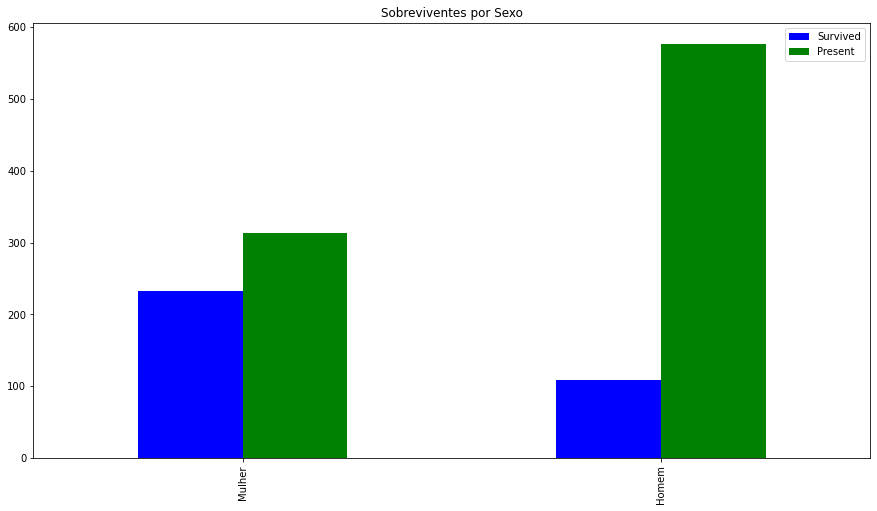

In [92]:
survived = df.groupby('Sex').sum().Survived
total = df.groupby('Sex').count().Survived

plot_df = pd.concat([survived, total], axis=1)
plot_df.columns = ['Survived', 'Present']
plot_df.index = ['Mulher', 'Homem']

plot_df.plot(kind='bar', color=list('bg'), title='Sobreviventes por Sexo', figsize=(15,8), legend=True)
plt.show()

É impressionante o dado de que a maioria das mulheres sobreviveram, enquanto no caso dos homens, foi a minoria. Isso provavelmente será uma feature de bastante relevância ao treinar o modelo.

É possível fazer uma análise semelhante para o porto de embarque:

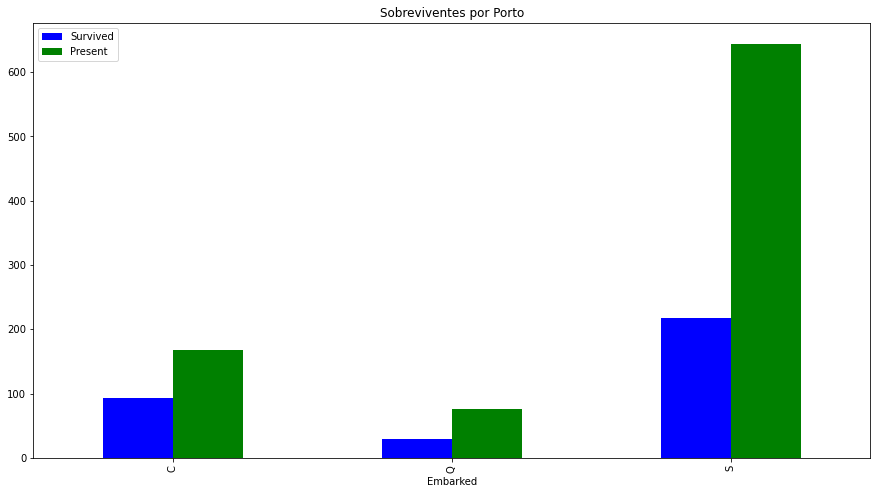

In [91]:
survived = df.groupby('Embarked').sum().Survived
total = df.groupby('Embarked').count().Survived

plot_df = pd.concat([survived, total], axis=1)
plot_df.columns = ['Survived', 'Present']

plot_df.plot(kind='bar', color=list('bg'), title='Sobreviventes por Porto', figsize=(15,8), legend=True)
plt.show()

As proporções são parecidas, para todos os portos, ou seja, não há grande diferença quanto a esse aspecto.

Por fim, irei fazer o plot de quanto cada classe está presente no dataset:

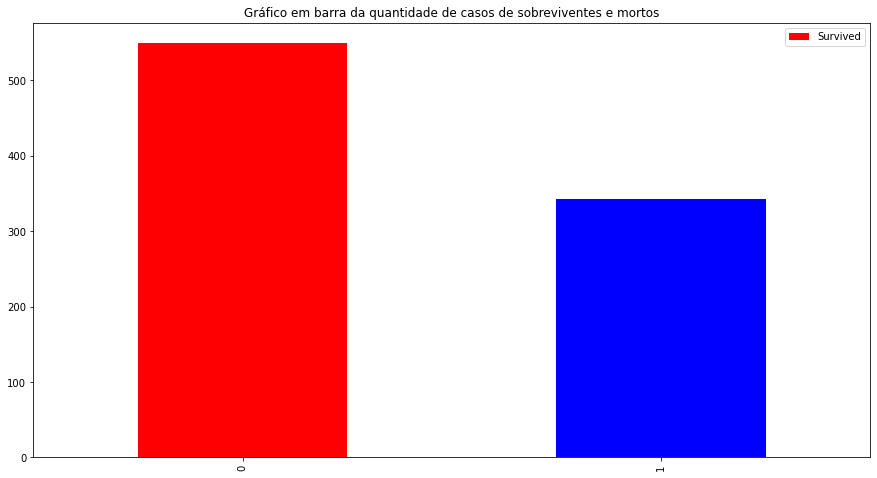

In [95]:
plt.figure(figsize=(15,8))
plt.title('Gráfico em barra da quantidade de casos de sobreviventes e mortos')
df.Survived.value_counts().plot(kind='bar', color=list('rb'), legend=True)
plt.show()

# O modelo

Irei construir um modelo de predição de Decision Trees, indo direto à variação de parâmetros para achar os melhores parâmetros para esse dataset. Será testado:

- max_depth -> controla o tamanho máximo da árvore. Iniciarei com 3, e caso, não haja overfit, vou aumentando.
- min_samples_leaf -> controla quantos splits são considerados, iniciarei com 5, quanto menor, maior a chance de overfit

In [96]:
from sklearn.model_selection import GridSearchCV

In [115]:
X = final_df.drop(['Survived'], axis=1).values
y = final_df.Survived.values

In [116]:
#splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

tree = DecisionTreeClassifier(random_state=0)

In [117]:
params = {
    'min_samples_leaf': [5, 4.5, 3.5, 2.5],
    'max_depth': [3, 5, 10]
}

clf = GridSearchCV(tree, params, n_jobs=-1, cv=3, verbose=True)
clf.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/home/sergio/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.8143794         nan        nan        nan 0.80689883        nan
        nan        nan 0.79193094        nan        nan        nan]
  category=UserWarning


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10],
                         'min_samples_leaf': [5, 4.5, 3.5, 2.5]},
             verbose=True)

In [125]:
clf.best_params_

{'max_depth': 3, 'min_samples_leaf': 5}

In [126]:
tree = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 5, random_state=0)

tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=0)

In [127]:
print('Train score: {:.3f}'.format(tree.score(X_train, y_train)))
print('Test score: {:.3f}'.format(tree.score(X_test, y_test)))

Train score: 0.835
Test score: 0.821


Modelo apresenta bom score e tanto o de treino quanto o de teste estão próximos, o que evidencia o não overfit. Considero um bom modelo.

Por fim, acho interessante, para o Decision Tree, analisar a importância das features e também, como será mostrado, um exemplo de árvore de decisão feita pelo modelo:

In [130]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["Not Survived", "Survived"],
               feature_names = final_df.drop(['Survived'], axis=1).columns.values, impurity=False, filled=True)

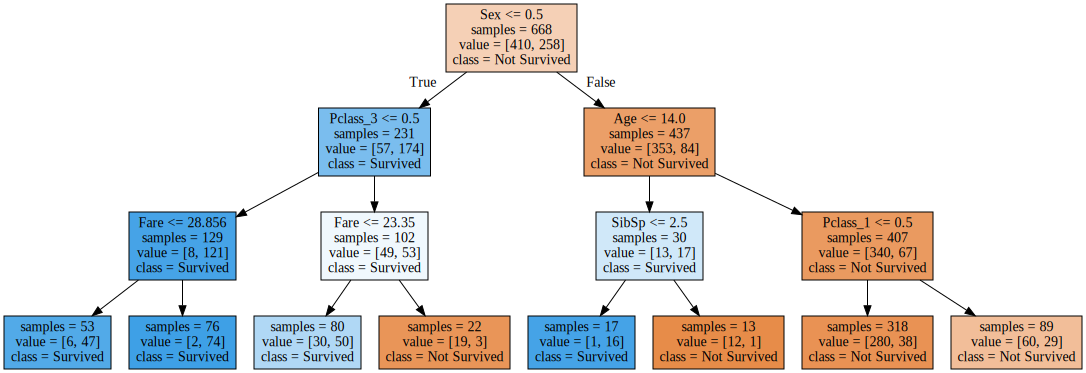

In [131]:
import graphviz

with open("tree.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph)

Agora, analisando a importância de cada feature para a tomada de decisão do modelo:

Text(0, 0.5, 'Feature')

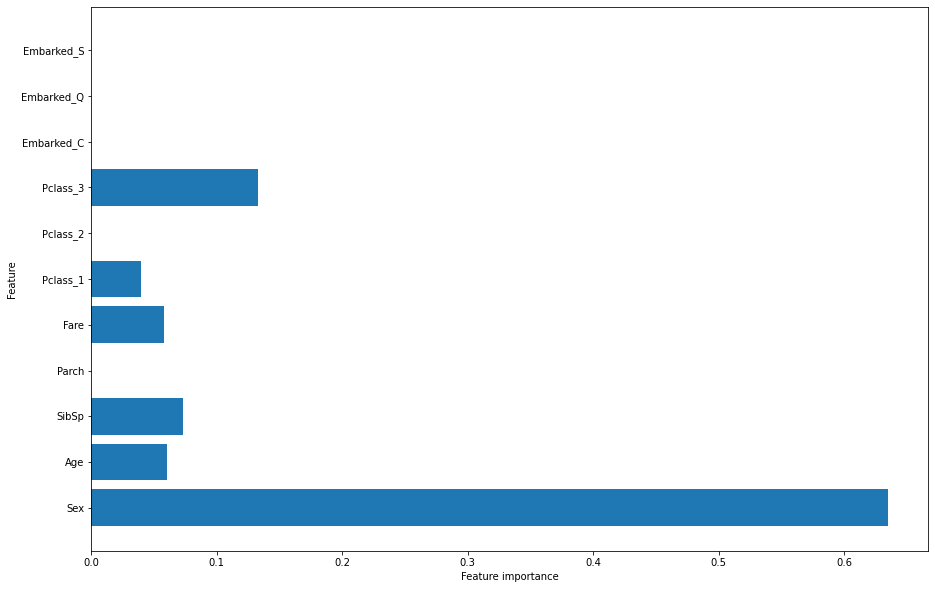

In [132]:
features = final_df.drop(['Survived'], axis=1).columns.values
n_features = len(features)

plt.figure(figsize=(15, 10))
plt.barh(range(n_features), tree.feature_importances_, align='center')
plt.yticks(np.arange(n_features), features)
plt.xlabel("Feature importance")
plt.ylabel("Feature")

Como previsto, anteriormente, pelos gráficos: o sexo tem enorme importância na decisão, já os portos onde houve o embarque apresentam pouquíssimo ou nenhum impacto na decisão de sobrevivência ou não de um passageiro o titanic.